In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
"""
Approximate intrinsics:
  f ~= focal_scale * max(w, h)
  principal point at image center
"""
def build_approx_K(w: int, h: int, focal_scale: float = 0.9) -> np.ndarray:   
    f = focal_scale * float(max(w, h))
    cx, cy = w / 2.0, h / 2.0
    K = np.array([[f, 0, cx],
                  [0, f, cy],
                  [0, 0, 1]], dtype=np.float64)
    return K

In [3]:
def detect_and_match(img1_gray, img2_gray, method="ORB", nfeatures=4000, ratio=0.75):
    if method.upper() == "SIFT":
        if not hasattr(cv, "SIFT_create"):
            raise RuntimeError("SIFT is not available in your OpenCV build. Use ORB instead.")
        det = cv.SIFT_create()
        k1, d1 = det.detectAndCompute(img1_gray, None)
        k2, d2 = det.detectAndCompute(img2_gray, None)
        if d1 is None or d2 is None:
            raise RuntimeError("No SIFT descriptors found. Try different images.")
        matcher = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    else:
        det = cv.ORB_create(nfeatures=nfeatures)
        k1, d1 = det.detectAndCompute(img1_gray, None)
        k2, d2 = det.detectAndCompute(img2_gray, None)
        if d1 is None or d2 is None:
            raise RuntimeError("No ORB descriptors found. Try different images.")
        matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)

    knn = matcher.knnMatch(d1, d2, k=2)

    good = []
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append(m)

    if len(good) < 12:
        raise RuntimeError(f"Not enough good matches ({len(good)}). Try more textured images or adjust ratio.")

    pts1 = np.float64([k1[m.queryIdx].pt for m in good])
    pts2 = np.float64([k2[m.trainIdx].pt for m in good])
    return k1, k2, good, pts1, pts2

In [4]:
# def main():
#     ap = argparse.ArgumentParser()
#     ap.add_argument("img1", help="Path to image 1")
#     ap.add_argument("img2", help="Path to image 2")
#     ap.add_argument("--method", choices=["ORB", "SIFT"], default="ORB")
#     ap.add_argument("--ratio", type=float, default=0.75, help="Lowe ratio test threshold")
#     ap.add_argument("--focal_scale", type=float, default=0.9, help="f ~= focal_scale * max(w,h)")
#     ap.add_argument("--threshold", type=float, default=1.0, help="RANSAC reprojection threshold (pixels)")
#     ap.add_argument("--confidence", type=float, default=0.999, help="RANSAC confidence")
#     ap.add_argument("--show_matches", action="store_true")
#     args = ap.parse_args()

#     img1 = cv.imread(args.img1)
#     img2 = cv.imread(args.img2)
#     if img1 is None or img2 is None:
#         raise FileNotFoundError("Could not read one of the images.")

#     g1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
#     g2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

#     h1, w1 = g1.shape[:2]
#     h2, w2 = g2.shape[:2]
#     if (w1, h1) != (w2, h2):
#         print("Warning: image sizes differ. Using K built from image 1 only; results may degrade.")

#     K = build_approx_K(w1, h1, focal_scale=args.focal_scale)
#     print("Approx K:\n", K)

#     k1, k2, matches, pts1, pts2 = detect_and_match(g1, g2, method=args.method, ratio=args.ratio)

#     # Estimate Essential matrix with RANSAC
#     E, inlier_mask = cv.findEssentialMat(
#         pts1, pts2, K,
#         method=cv.RANSAC,
#         prob=args.confidence,
#         threshold=args.threshold)
#     if E is None or inlier_mask is None:
#         raise RuntimeError("findEssentialMat failed. Try different images or adjust thresholds.")

#     inlier_mask = inlier_mask.ravel().astype(bool)
#     inliers1 = pts1[inlier_mask]
#     inliers2 = pts2[inlier_mask]

#     print(f"Matches: {len(matches)} | E-inliers: {len(inliers1)}")
#     print("E:\n", E)

#     # Recover pose (R, t) up to scale
#     # recoverPose also enforces a cheirality check to pick a valid decomposition
#     points, R, t, pose_mask = cv.recoverPose(E, inliers1, inliers2, K)
#     print(f"recoverPose inliers (cheirality-consistent): {int(points)}")
#     print("R:\n", R)
#     print("t (unit-norm direction, scale unknown):\n", t / (np.linalg.norm(t) + 1e-12))

#     if args.show_matches:
#         # Visualize inlier matches used for E (first 200)
#         inlier_matches = [m for m, keep in zip(matches, inlier_mask) if keep]
#         vis = cv.drawMatches(img1, k1, img2, k2, inlier_matches[:200], None,
#                              flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#         cv.imshow("Essential inlier matches (first 200)", vis)
#         cv.waitKey(0)
#         cv.destroyAllWindows()

In [5]:
def main(img_path1, img_path2, method="ORB", ratio=0.75, focal_scale=0.9, threshold=1.0, confidence=0.999, show_matches=True):
    # 1. Load Images
    img1 = cv.imread(img_path1)
    img2 = cv.imread(img_path2)
    
    if img1 is None or img2 is None:
        raise FileNotFoundError("Could not read one of the images. Check your file paths.")

    # 2. Pre-processing
    g1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    g2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    h1, w1 = g1.shape[:2]

    # 3. Build K and Match Features
    K = build_approx_K(w1, h1, focal_scale=focal_scale)
    k1, k2, matches, pts1, pts2 = detect_and_match(g1, g2, method=method, ratio=ratio)

    # 4. Estimate Essential matrix with RANSAC
    E, inlier_mask = cv.findEssentialMat(
        pts1, pts2, K, 
        method=cv.RANSAC, 
        prob=confidence, 
        threshold=threshold
    )
    
    if E is None:
        raise RuntimeError("Essential Matrix estimation failed.")

    # Filter inliers
    inlier_mask = inlier_mask.ravel().astype(bool)
    inliers1 = pts1[inlier_mask]
    inliers2 = pts2[inlier_mask]

    # 5. Recover Pose
    points, R, t, pose_mask = cv.recoverPose(E, inliers1, inliers2, K)
    
    # Print Results
    print(f"--- Results for {method} ---")
    print(f"Total Matches: {len(matches)}")
    print(f"RANSAC Inliers: {len(inliers1)}")
    print(f"Recovered Pose Inliers: {int(points)}")
    print("\nRotation Matrix (R):\n", R)
    print("\nTranslation Vector (t):\n", t / (np.linalg.norm(t) + 1e-12))

    # 6. Visualization (Jupyter Friendly)
    if show_matches:
        inlier_matches = [m for m, keep in zip(matches, inlier_mask) if keep]
        vis = cv.drawMatches(img1, k1, img2, k2, inlier_matches[:100], None, 
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
        # Convert BGR to RGB for Matplotlib
        vis_rgb = cv.cvtColor(vis, cv.COLOR_BGR2RGB)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(vis_rgb)
        plt.title(f"Top 100 Inlier Matches ({method})")
        plt.axis('off')
        plt.show()

    return R, t

In [6]:
img_dir = r'D:\Python things\middle-ml-cv-roadmap\data\raw'
img_1 = 'img_example_11.jpg'
img_2 = 'img_example_12.jpg'
img_1_path = os.path.join(img_dir, img_1)
img_2_path = os.path.join(img_dir, img_2)

--- Results for ORB ---
Total Matches: 298
RANSAC Inliers: 158
Recovered Pose Inliers: 158

Rotation Matrix (R):
 [[ 0.87937123 -0.03439367  0.47489296]
 [ 0.03564768  0.99934414  0.00636684]
 [-0.47480047  0.01133001  0.88002053]]

Translation Vector (t):
 [[-0.99871691]
 [ 0.05014036]
 [-0.00710522]]


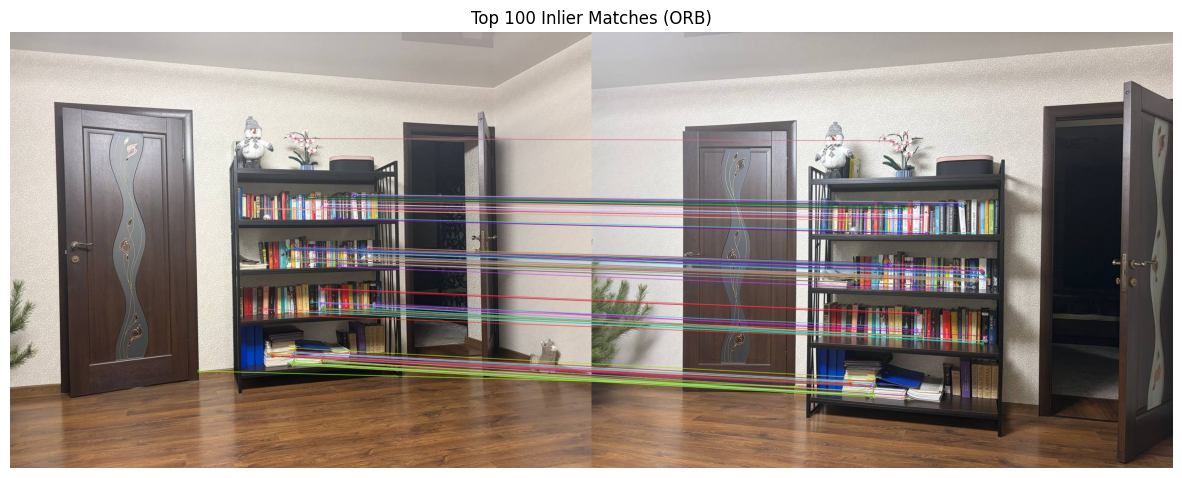

(array([[ 0.87937123, -0.03439367,  0.47489296],
        [ 0.03564768,  0.99934414,  0.00636684],
        [-0.47480047,  0.01133001,  0.88002053]]),
 array([[-0.99871691],
        [ 0.05014036],
        [-0.00710522]]))

In [7]:
main(img_1_path, img_2_path)